In [1]:
import keras
keras.__version__

'3.5.0'

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import random
import shutil
import numpy as np

In [3]:
# Set random seed for reproducibility
random.seed(42)
tf.random.set_seed(42)

# Function to create train, validation, and test sets
def create_dataset_splits(source_dir, train_dir, val_dir, test_dir, num_train, num_val, num_test):
    for dir in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(dir, 'cats'), exist_ok=True)
        os.makedirs(os.path.join(dir, 'dogs'), exist_ok=True)

    for animal in ['cat', 'dog']:
        animal_files = [f for f in os.listdir(source_dir) if f.startswith(animal)]
        random.shuffle(animal_files)

        for i, file in enumerate(animal_files):
            if i < num_train:
                shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, f'{animal}s', file))
            elif i < num_train + num_val:
                shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, f'{animal}s', file))
            elif i < num_train + num_val + num_test:
                shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, f'{animal}s', file))
            else:
                break

    print(f"Train set: {len(os.listdir(os.path.join(train_dir, 'cats'))) + len(os.listdir(os.path.join(train_dir, 'dogs')))} images")
    print(f"Validation set: {len(os.listdir(os.path.join(val_dir, 'cats'))) + len(os.listdir(os.path.join(val_dir, 'dogs')))} images")
    print(f"Test set: {len(os.listdir(os.path.join(test_dir, 'cats'))) + len(os.listdir(os.path.join(test_dir, 'dogs')))} images")


# Create dataset splits
source_dir = 'D:/Test/Deep_Learning/Assignment_3/dogs-vs-cats/train'
train_dir = 'D:/Test/Deep_Learning/Assignment_3/dataset1/train'
val_dir = 'D:/Test/Deep_Learning/Assignment_3/dataset1/validation'
test_dir = 'D:/Test/Deep_Learning/Assignment_3/dataset1/test'

create_dataset_splits(source_dir, train_dir, val_dir, test_dir, 1000, 500, 500)


Train set: 2000 images
Validation set: 1000 images
Test set: 1000 images


In [4]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                    batch_size=32, class_mode='binary')

validation_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(150, 150),
                                                            batch_size=32, class_mode='binary')

test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(150, 150),
                                                      batch_size=32, class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [6]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import os
import numpy as np
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'D:/Test/Deep_Learning/Assignment_3/cats_and_dogs_small1'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 4000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # or any other pretrained model
from tensorflow.keras.models import Model

# Define base directory for the dataset
base_dir = 'D:/Test/Deep_Learning/Assignment_3/cats_and_dogs_small1'

# Define directories for training, validation, and testing
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Initialize ImageDataGenerator for rescaling
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# Load the pretrained model (e.g., VGG16) without the top layers
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))  # Adjust shape based on your model's output
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)  # Set shuffle=False to maintain order for labels

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        
        if i * batch_size >= sample_count:
            break
    
    return features, labels

# Extract features and labels from training, validation, and test datasets
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# Print shapes of extracted features and labels for verification
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Validation features shape:", validation_features.shape)
print("Validation labels shape:", validation_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Found 4000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━

In [10]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [12]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9841 - loss: 0.0623 - val_accuracy: 1.0000 - val_loss: 2.8534e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 1.0000 - loss: 3.1856e-04 - val_accuracy: 1.0000 - val_loss: 4.1489e-05
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 1.0000 - loss: 1.0553e-04 - val_accuracy: 1.0000 - val_loss: 1.8596e-05
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 1.0000 - loss: 4.2832e-05 - val_accuracy: 1.0000 - val_loss: 1.1559e-05
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 1.0000 - loss: 3.2571e-05 - val_accuracy: 1.0000 - val_loss: 8.0040e-06
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 1.0000 - loss: 2.0897e-05 - val_accuracy: 1.0000 - val_loss: 6.3289e-06
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 1.0000 - loss: 1.6469e-05 - val_accuracy: 1.0000 - val_loss: 5.1756e-06
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32

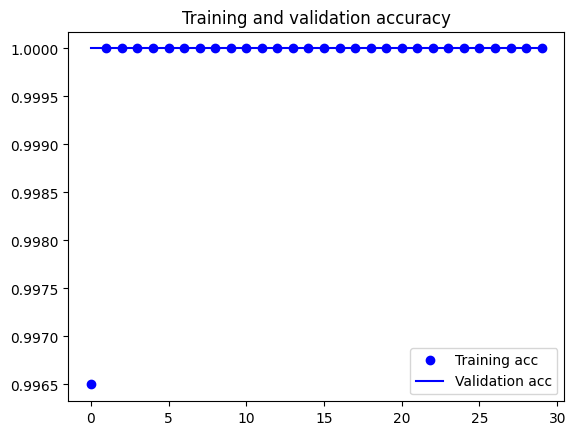

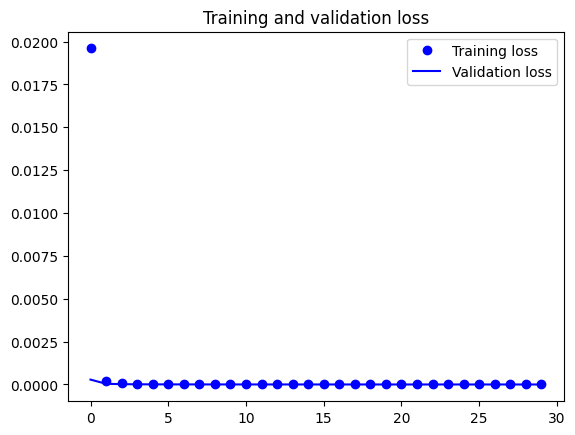

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# from keras import models
# from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [17]:
conv_base.trainable = False

In [18]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [20]:
# from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30


C:\Users\1041238\Anaconda3\envs\deeplearn\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 227s - 2s/step - accuracy: 0.6850 - loss: 0.5946 - val_accuracy: 0.8320 - val_loss: 0.4441
Epoch 2/30
100/100 - 261s - 3s/step - accuracy: 0.7790 - loss: 0.4846 - val_accuracy: 0.8630 - val_loss: 0.3619
Epoch 3/30
100/100 - 0s - 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 4/30


C:\Users\1041238\Anaconda3\envs\deeplearn\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


KeyboardInterrupt: 

In [21]:
model.save('cats_and_dogs_small_3.keras')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Problem 5: Fine Tune

In [22]:
import os
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
# Load VGG16 model without top layers
conv_base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Unfreeze the last three convolutional layers
for layer in conv_base_vgg.layers[-3:]:
    layer.trainable = True

# Print layer names to verify
for i, layer in enumerate(conv_base_vgg.layers):
    print(i, layer.name)

0 input_layer_5
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [24]:
# Load Xception model without top layers
conv_base_xception = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Unfreeze the last two separable convolutional layers and the dense classification layers
for layer in conv_base_xception.layers[-2:]:  # Last two separable convolutional layers
    layer.trainable = True

# Also unfreeze dense classification layers if needed (adjust based on your architecture)
for layer in conv_base_xception.layers[-5:]:  # Adjust this slice based on your needs
    layer.trainable = True

# Print layer names to verify
for i, layer in enumerate(conv_base_xception.layers):
    print(i, layer.name)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step
0 input_layer_6
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 bl

In [27]:
# Image data generators for VGG16 (150x150) and Xception (299x299)
# datagen_vgg = ImageDataGenerator(rescale=1./255)
# datagen_xception = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(        
        train_dir,        
        target_size=(299, 299),
        batch_size=32,        
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [29]:
# For Xception
model_xception = models.Sequential()
model_xception.add(conv_base_xception)
model_xception.add(layers.GlobalAveragePooling2D())
model_xception.add(layers.Dense(256, activation='relu'))
model_xception.add(layers.Dense(1, activation='sigmoid'))

model_xception.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [ ]:
# Train VGG16 model
# history_vgg = model_vgg.fit(train_generator_vgg,
#                              steps_per_epoch=100,
#                              epochs=30)

# Train Xception model
history_xception = model_xception.fit(train_generator,
                                       steps_per_epoch=100,
                                       epochs=30)

Epoch 1/30


In [ ]:
# Evaluate Xception model
val_loss_xception, val_accuracy_xception = model_xception.evaluate(validation_generator)
print(f'Xception Validation Loss: {val_loss_xception}, Validation Accuracy: {val_accuracy_xception}')